In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import data

In [0]:
#grab all jpg file in folder(train_images)
img = glob.glob('/content/drive/Shared drives/python/kaggle/steel_defect/train_images/*.jpg')
df_img = pd.DataFrame(img);
#read train.csv
df = pd.read_csv('/content/drive/Shared drives/python/kaggle/steel_defect/train.csv')

In [4]:
df.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
df_img.head()

,0
0,/content/drive/Shared drives/python/kaggle/ste...
1,/content/drive/Shared drives/python/kaggle/ste...
2,/content/drive/Shared drives/python/kaggle/ste...
3,/content/drive/Shared drives/python/kaggle/ste...
4,/content/drive/Shared drives/python/kaggle/ste...


# preprocessing

In [0]:
#replace no-mask as 0
df = df.fillna(0)
#spilt class from ImageId_ClassId
df['class'] = df.ImageId_ClassId.map(lambda x : x.split('_')[1]).astype('int8')
#spilt image name from ImageId_ClassId
df['image'] = df.ImageId_ClassId.map(lambda x : x.split('_')[0])
df.drop('ImageId_ClassId',axis=1,inplace=True)

In [0]:
#aggregate masks per image
df_aggre = pd.DataFrame([])
df_aggre['mask'] = np.split(df['EncodedPixels'].values,len(df)/4)
df_aggre['image'] = df.image.unique()

In [0]:
#merge df_image to df_aggre by image name
df_img['image'] = df_img[0].map(lambda x : x.split('/')[-1])
df_img = df_img.rename({0:'url'},axis=1)
df_aggre = df_aggre.merge(df_img)

In [9]:
df_aggre.head()

,mask,image,url
0,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,0002cc93b.jpg,/content/drive/Shared drives/python/kaggle/ste...
1,"[0, 0, 0, 0]",00031f466.jpg,/content/drive/Shared drives/python/kaggle/ste...
2,"[0, 0, 0, 0]",000418bfc.jpg,/content/drive/Shared drives/python/kaggle/ste...
3,"[0, 0, 0, 0]",000789191.jpg,/content/drive/Shared drives/python/kaggle/ste...
4,"[0, 0, 18661 28 18863 82 19091 110 19347 110 1...",0007a71bf.jpg,/content/drive/Shared drives/python/kaggle/ste...


# utils

In [0]:
#function of transfering EncodedPixels to mask image array
def mask_decode(code):
    if code == 0:
        return np.zeros((256,1600,1)).astype('int8')
    else:
        code = np.array(code.split(' ')).astype('int32').reshape(-1,2)
        number = np.split(code,2,axis=1)[0].reshape(-1)
        times = np.split(code,2,axis=1)[1].reshape(-1)
        pixel = np.concatenate([np.arange(i,i+j) for i,j in zip(number,times)])
        pixel = pixel[pixel<409600]
        mask_img = np.zeros(256*1600,dtype=int).astype('int8')
        mask_img[pixel] = 1
        mask_img = mask_img.reshape(1600,256)
        mask_img = mask_img.T.reshape(256,1600,1)
        return mask_img
#complie mask1-4 into one
def compile_mask(li):
    mask_4 = []
    for i in li:
        mask_4.append(mask_decode(i))
    mask_4 = np.dstack(mask_4)
    mask_4 = mask_4[np.newaxis,:]
    return mask_4
#----------------------------------------------------------------------------------
#function of transfering mask image array to EncodedPixels
def mask_encode(mask):
    flat = np.argwhere(mask.T.reshape(-1)).reshape(-1)
    number = [flat[0]]
    times = []
    count = 1
    for i in range(len(flat)-1):
        if i == len(flat)-2:
            count += 1
            times.append(count) 
        elif flat[i+1] - flat[i] == 1:
            count += 1
        elif flat[i+1] - flat[i] != 1:
            number.append(flat[i+1])
            times.append(count)
            count = 1 
    code = np.stack([number,times],axis=1).reshape(-1).astype('str')
    code = ' '.join(code)
    return code
#---------------------------------------------------------------------------------- 
#function of transfering url of training image to image array 
def train_importer(url):
    img = cv2.imread(url,0).reshape(256,1600,1)[np.newaxis,:]
    return img
#---------------------------------------------------------------------------------- 
#function of generating batch data of training image array(x),mask image array(y) for batch training
def data_importer(df):
    while 1:
        sample = np.random.randint(0,len(df),size=batch_size)
        train = np.vstack(df['url'].iloc[sample].apply(train_importer).values)/255
        mask = np.vstack(df['mask'].iloc[sample].apply(compile_mask).values)
        yield train,mask

In [0]:
#split train&test
train_x,test_x,_,_ = train_test_split(df_aggre,range(len(df_aggre)),test_size=0.2,random_state=0)
train_generator = data_importer(train_x)
test_generator = data_importer(test_x)

# testing

([], <a list of 0 Text yticklabel objects>)

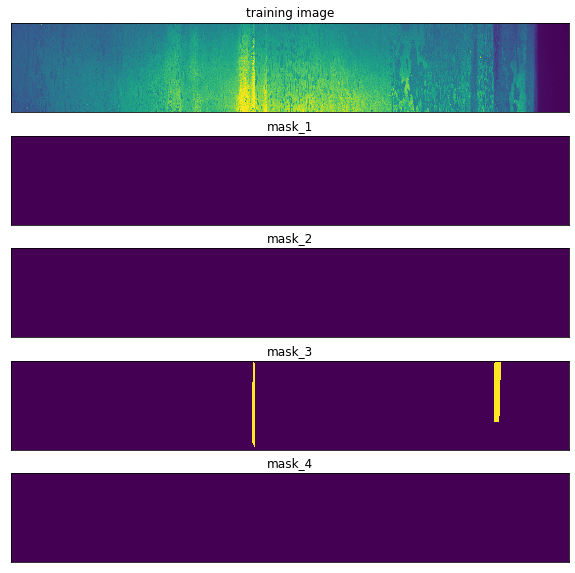

In [12]:
n = np.random.randint(0,len(df_aggre),1)[0]
train_pic = train_importer(df_aggre['url'].iloc[n])[0].reshape(256,1600)
mask_1 = compile_mask(df_aggre['mask'].iloc[n])[0][:,:,0].reshape(256,1600)
mask_2 = compile_mask(df_aggre['mask'].iloc[n])[0][:,:,1].reshape(256,1600)
mask_3 = compile_mask(df_aggre['mask'].iloc[n])[0][:,:,2].reshape(256,1600)
mask_4 = compile_mask(df_aggre['mask'].iloc[n])[0][:,:,3].reshape(256,1600)
plt.figure(figsize=(10,10))  
plt.subplot(5,1,1)
plt.imshow(train_pic)
plt.title('training image')
plt.xticks([]);plt.yticks([])
plt.subplot(5,1,2)
plt.imshow(mask_1)
plt.title('mask_1')
plt.xticks([]);plt.yticks([])
plt.subplot(5,1,3)
plt.imshow(mask_2)
plt.title('mask_2')
plt.xticks([]);plt.yticks([])
plt.subplot(5,1,4)
plt.imshow(mask_3)
plt.title('mask_3')
plt.xticks([]);plt.yticks([])
plt.subplot(5,1,5)
plt.imshow(mask_4)
plt.title('mask_4')
plt.xticks([]);plt.yticks([])

In [13]:
train_importer(df_aggre['url'][0]).shape

(1, 256, 1600, 1)

In [14]:
compile_mask(df_aggre['mask'][0]).shape

(1, 256, 1600, 4)

# create model

In [15]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Conv2DTranspose,Input,Activation,concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

In [0]:
#create convolution block(conv2D->batchnorm->relu->conv2D->batchnorm->relu)
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
# ---------------------------------------------------------------------------------------
#create unet model
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * backend.sum(intersection) + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [17]:
# summary of model for illustration
input_img = Input((256, 1600, 1), name='img')
model_illustrate = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model_illustrate.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 16 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 1600, 16 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 1600, 16 0           batch_normalization[0][0]        
_____________

In [0]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
# assign batch_size for training model
batch_size = 10

In [20]:
# training model
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1])
model.fit_generator(train_generator,steps_per_epoch=len(train_x)//(batch_size),
                    validation_data=test_generator,validation_steps=len(test_x)//(batch_size),epochs=10,workers=-1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1005/1005 [==============================] - 782s 778ms/step - loss: 0.0933 - acc: 0.9861 - f1: 0.0013 - val_loss: 0.0271 - val_acc: 0.9930 - val_f1: 0.0136
Epoch 2/10
1005/1005 [==============================] - 743s 740ms/step - loss: 0.0283 - acc: 0.9925 - f1: 0.0120 - val_loss: 0.0272 - val_acc: 0.9921 - val_f1: 0.0298
Epoch 3/10
1005/1005 [==============================] - 732s 728ms/step - loss: 0.0247 - acc: 0.9929 - f1: 0.0181 - val_loss: 0.0210 - val_acc: 0.9939 - val_f1: 0.0306
Epoch 4/10
1005/1005 [==============================] - 730s 726ms/step - loss: 0.0232 - acc: 0.9932 - f1: 0.0210 - val_loss: 0.0184 - val_acc: 0.9946 - val_f1: 0.0208
Epoch 5/10
1005/1005 [==============================] - 726s 722ms/step - loss: 0.0217 - acc: 0.9936 - f1: 0.0231 - val_loss: 0.0279 - val_acc: 0.9901 - val_f1: 0.0409
Epoch 6/10
1005/1005 [==============================] - 722s 719ms

# illustration

In [0]:
#create data importer for model prediction
def test_importer(df):
    while 1:
        test = np.vstack(df['url'][0:10].apply(train_importer).values)/255
        yield test

#show test_image / mask(*4) / predict_mask(*4)
def test_show(df):
    pred_generator = test_importer(df)
    pred = model.predict_generator(pred_generator,steps=1)
    n = np.random.randint(0,10,1)[0]
    pred_pic = pred[n]
    pred_pic = np.where(pred_pic > 0.4,1,0)
    pred_1 = pred_pic[:,:,0].reshape(256,1600) ; pred_2 = pred_pic[:,:,1].reshape(256,1600)  ; pred_3 = pred_pic[:,:,2].reshape(256,1600)  ; pred_4 = pred_pic[:,:,3].reshape(256,1600)
    train_pic = train_importer(df['url'].iloc[n])[0].reshape(256,1600)
    mask_pic = compile_mask(df['mask'].iloc[n])[0]
    mask_1 = mask_pic[:,:,0].reshape(256,1600) ; mask_2 = mask_pic[:,:,1].reshape(256,1600)  ; mask_3 = mask_pic[:,:,2].reshape(256,1600)  ; mask_4 = mask_pic[:,:,3].reshape(256,1600)
    plt.figure(figsize=(20,20))
    plt.subplot(9,1,1)
    plt.imshow(train_pic);plt.title('training image');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,2)
    plt.imshow(pred_1);plt.title('predict_class1');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,3)
    plt.imshow(mask_1);plt.title('mask_class1');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,4)
    plt.imshow(pred_2);plt.title('predict_class2');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,5)
    plt.imshow(mask_2);plt.title('mask_class2');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,6)
    plt.imshow(pred_3);plt.title('predict_class3');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,7)
    plt.imshow(mask_3);plt.title('mask_class3');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,8)
    plt.imshow(pred_4);plt.title('predict_class4');plt.xticks([]);plt.yticks([])
    plt.subplot(9,1,9)
    plt.imshow(mask_4);plt.title('mask_class4');plt.xticks([]);plt.yticks([])

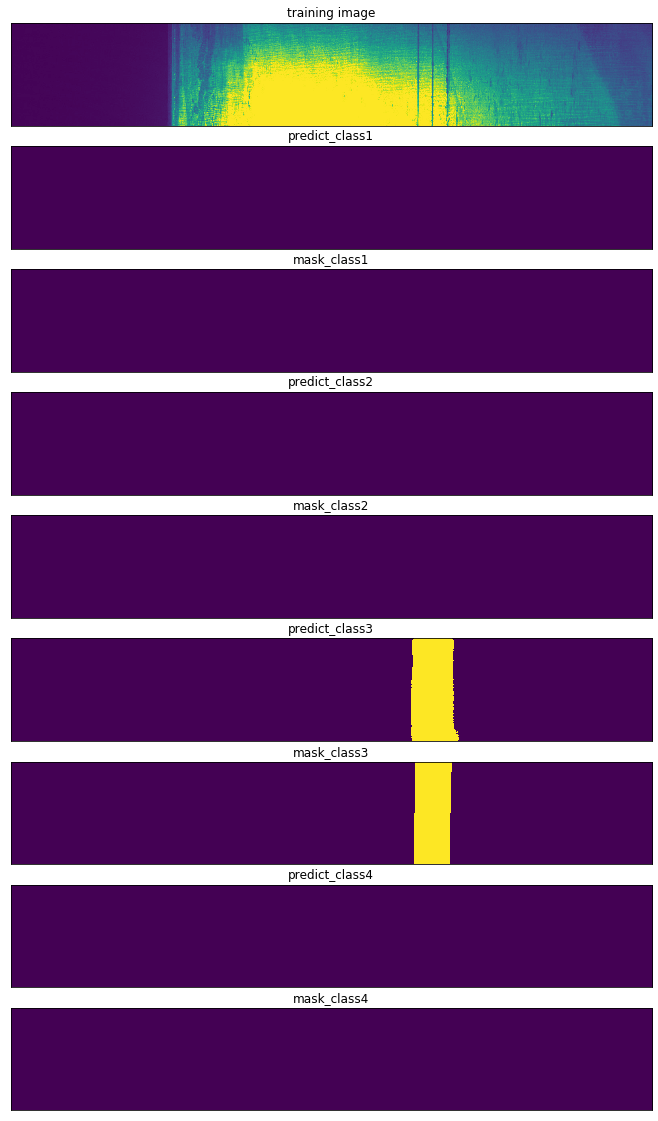

In [44]:
test_show(test_x)